### Run some more tests

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math

In [2]:
vocab_size = 27

In [3]:
%run names.py

## import the layers from before

In [4]:
%run sequence.py

In [5]:
def add_block(fan_in, hidden_l, nln=Relu()):
    lin = Linear(fan_in, hidden_l, bias=False)
    lin.kaiming()
    lin.magic()
    return [
        FlattenConsecutive(2),
        lin, 
        nln,
        nn.LayerNorm(hidden_l),
    ]

In [6]:
@torch.no_grad()
def split_loss(split):
    dx = [s[0] for s in split]
    dy = torch.tensor([s[1] for s in split])
    logits = md(dx)
    return F.cross_entropy(logits, dy).item()

In [7]:
def create_model(context_length, hidden_size, embed_size):
    seq = [Embedding(vocab_size, embed_size)]

    fan_in = embed_size * 2
    for _ in range(int(math.log(context_length, 2))):
        seq = seq + add_block(fan_in, hidden_size)
        fan_in = hidden_size * 2

    final = Linear(hidden_size, vocab_size, bias=True)
    final.magic(True)
    seq.append(final)

    model = Sequential(seq)
    
    model.init_grad()

    return model

In [8]:
context_length = 8

ns = Names(context_length)

ns.get_names("names.txt")

x_names, y_names = ns.get_xys()
samples_length = len(y_names)
train_length = math.floor(samples_length * .8)
dev_offset = math.floor(samples_length * .9)

dev = list(zip(x_names[train_length: dev_offset], y_names[train_length: dev_offset]))
test = list(zip(x_names[dev_offset:], y_names[dev_offset:]))

train = list(zip(x_names[:train_length], y_names[:train_length]))

def sample_names(sample_size = 5, p = train):
    samples = random.sample(p, sample_size)
    x_samples = [s[0] for s in samples]
    y_samples = [s[1] for s in samples]
    return x_samples, y_samples

In [13]:
epochs = 140
batch_size = 160
sample_loops = 2000

hidden_size = 100

embed = 9

optimizer = "adam"

# lr_step = {
#     0: { 0: .1},
#     3: { 0: .1},
#     6: { 0: .1, 100: .02},
#     9: { 0: .1, 100: .02}
# }

# lrs = lr_step[embed]

md = create_model(context_length, hidden_size, embed)

learning_rate = 0.01

opti = torch.optim.AdamW(md.parameters(), lr=learning_rate)

print(opti.state_dict()['param_groups'][0]['lr'])

parameter_size = sum(p.nelement() for p in md.parameters()) # number of parameters in total

m_setup = {
    "embed": embed,
    "epochs": epochs,
    "batch_size": batch_size,
    "sample_loops": sample_loops,
    "hidden_size": hidden_size,
    "optimizer": {
        "implementation": optimizer,
        "learning_rate": learning_rate
    },
    "context_length": context_length,
    "parameter_size": parameter_size
}

running_loss = []
running_lr = []

ud_ratio = []

m_setup

0.01


{'embed': 9,
 'epochs': 140,
 'batch_size': 160,
 'sample_loops': 2000,
 'hidden_size': 100,
 'optimizer': {'implementation': 'adam', 'learning_rate': 0.01},
 'context_length': 8,
 'parameter_size': 45370}

In [14]:
for ep in range(epochs):
    epoch_loss = 0
    previous_loss = 200
    for s in range(sample_loops):
        x, y = sample_names(batch_size)
        Y = torch.tensor(y)
        X = torch.tensor(x)

        logits = md(X)

        loss = F.cross_entropy(logits, Y) # loss function
        
        with torch.no_grad():
            epoch_loss += loss

        opti.zero_grad(set_to_none=True)
        loss.backward()
        opti.step()

    #just keep any epoch stuff in a no grad block
    with torch.no_grad():
        # if ep in lrs:
        #     learning_rate = lrs[ep]
        olr = opti.state_dict()['param_groups'][0]['lr']

        average_loss = epoch_loss.item() / sample_loops

        if average_loss > previous_loss:
            break

        previous_loss = average_loss

        running_loss.append(epoch_loss.item())
        running_lr.append(learning_rate)

        ud_ratio.append([ (olr*p.grad.std()/ p.data.std()).log10().item() for p in md.parameters() ])
    
        if ep % 10 == 0:
            print(average_loss)
            print(olr)

2.250982666015625
0.01
1.951348388671875
0.01
1.92930859375
0.01
1.9169417724609374
0.01
1.9131243896484376
0.01
1.9098370361328125
0.01
1.908766845703125
0.01
1.9053609619140626
0.01
1.9052825927734376
0.01
1.9027403564453125
0.01
1.8967978515625
0.01
1.8954451904296874
0.01
1.8964146728515625
0.01
1.889831298828125
0.01


In [15]:
tr = split_loss(train)
dv = split_loss(dev)
print("train", tr, "dev", dv, m_setup)

train 1.8896089792251587 dev 2.080709218978882 {'embed': 9, 'epochs': 140, 'batch_size': 160, 'sample_loops': 2000, 'hidden_size': 100, 'optimizer': {'implementation': 'adam', 'learning_rate': 0.01}, 'context_length': 8, 'parameter_size': 45370}


In [71]:
import matplotlib.pyplot as plt

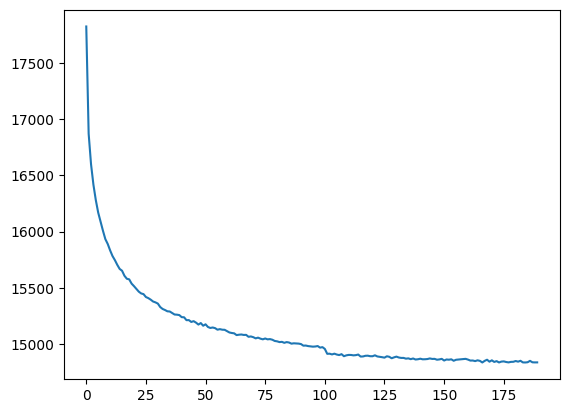

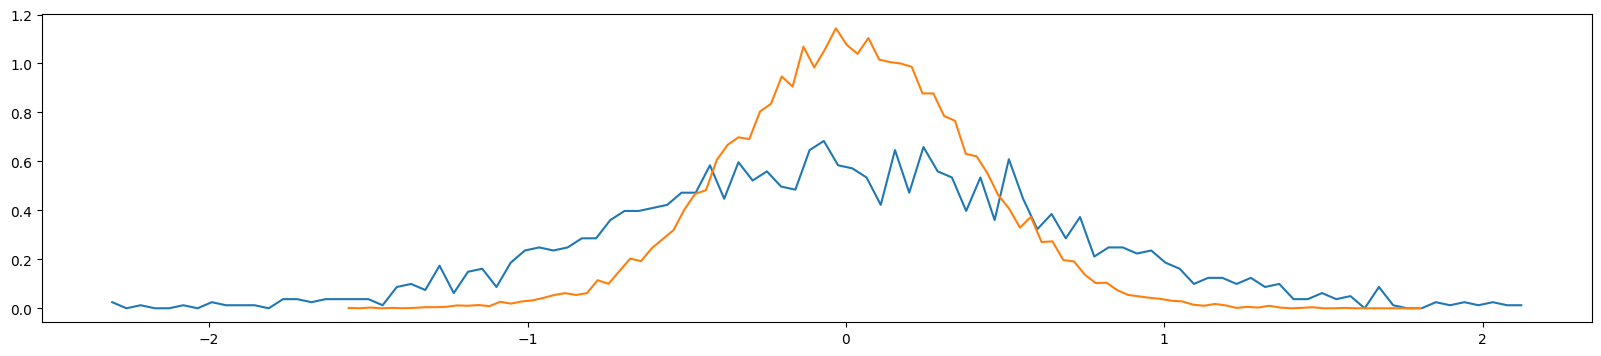

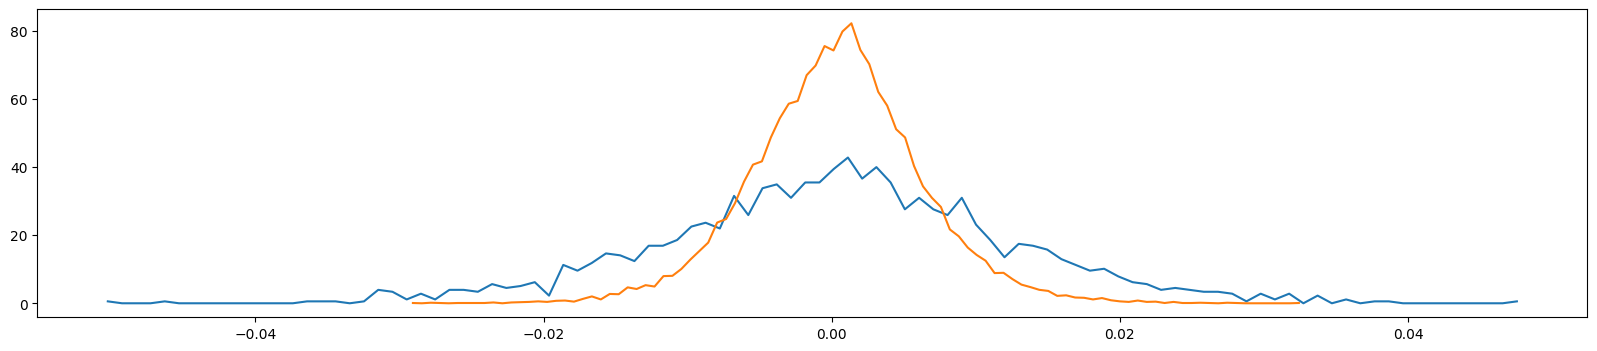

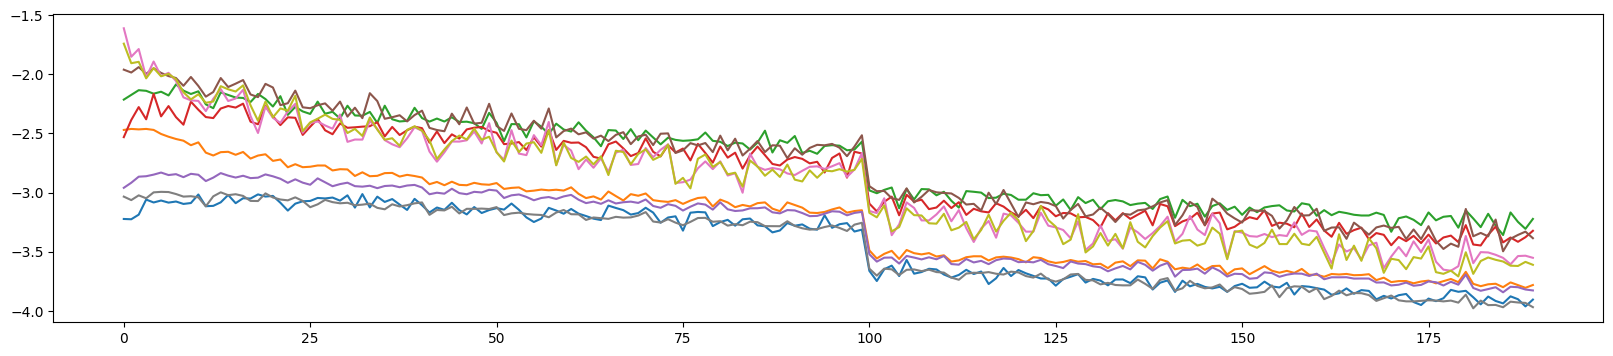

In [73]:
model = md


eps = [i for i in range(len(running_loss))]
ls = [l for l in running_loss]

plt.plot(eps, ls)

t = model.layers[2].weight.detach()
hy, hx = torch.histogram(t, density=True)
plt.figure(figsize=(20,4))
plt.plot(hx.detach()[1:], hy.detach())
t2 = model.layers[-4].weight.detach()
h2y, h2x = torch.histogram(t2, density=True)
plt.plot(h2x.detach()[1:], h2y.detach())

# look at our gradient distributions

t = model.layers[2].weight.grad.detach()
hy, hx = torch.histogram(t, density=True)
plt.figure(figsize=(20,4))
plt.plot(hx.detach()[1:], hy.detach())
t2 = model.layers[-4].weight.grad.detach()
h2y, h2x = torch.histogram(t2, density=True)
plt.plot(h2x.detach()[1:], h2y.detach())


plt.figure(figsize=(20,4))
plt.plot(ud_ratio)

In [ ]:
context_length = 4
epochs = 190
batch_size = 400
sample_loops = 8000

hidden_size = 100

embed = 9

lr_step = {
    0: { 0: .1},
    3: { 0: .1},
    9: { 0: .1, 100: .02}
}

lrs = lr_step[embed]

m_setup = {
    "embed": embed,
    "epochs": epochs,
    "batch_size": batch_size,
    "sample_loops": sample_loops,
    "hidden_size": hidden_size,
    "learning_rates": lrs,
    "context_length": context_length
}

m_setup

Best settings

train 1.8896089792251587 dev 2.080709218978882 {'embed': 9, 'epochs': 140, 'batch_size': 160, 'sample_loops': 2000, 'hidden_size': 100, 'optimizer': {'implementation': 'adam', 'learning_rate': 0.01}, 'context_length': 8, 'parameter_size': 45370}

train 1.92476224899292 dev 2.073906898498535 {'embed': 9, 'epochs': 40, 'batch_size': 140, 'sample_loops': 2000, 'hidden_size': 100, 'optimizer': {'implementation': 'adam', 'learning_rate': 0.01}, 'context_length': 8, 'parameter_size': 45370}

train 1.8550971746444702 dev 2.0642249584198 {'embed': 9, 'epochs': 190, 'batch_size': 400, 'sample_loops': 8000, 'hidden_size': 100, 'optimizer':{'implementation': 'sgd', 'learning_rate':{0: 0.1, 100: 0.02}}
